In [3]:
import glob
import time
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn import svm
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [4]:
# Read in cars and notcars
cars = glob.glob('./training_images/vehicles/**/*.png', recursive=True)
notcars = glob.glob('./training_images/non-vehicles/**/*.png', recursive=True)

print('Number of cars: ', len(cars))
print('Number of not cars: ', len(notcars))

Number of cars:  8792
Number of not cars:  8968


In [5]:
def bgr_to_rgb(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

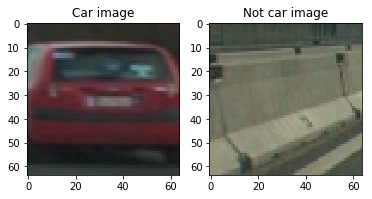

In [6]:
rand_car_i = random.randint(0, len(cars)-1)
rand_notcar_i = random.randint(0, len(notcars)-1)
example_car = cv2.imread(cars[rand_car_i])
example_notcar = cv2.imread(notcars[rand_notcar_i])
fig = plt.figure()
plt.subplot(121)
plt.imshow(bgr_to_rgb(example_car))
plt.title('Car image')
plt.subplot(122)
plt.imshow(bgr_to_rgb(example_notcar))
plt.title('Not car image')

In [7]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 656] # Min and max in y to search in slide_window()
x_start_stop=[None, None]
xy_window=(96, 96)
xy_overlap=(0.5, 0.5)

In [8]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):

    # features = cv2.resize(img, size).ravel()
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):

    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # if image.shape[0] != spatial_size[0] or image.shape[1] != spatial_size[1]:
        #     image = np.resize(image, (spatial_size[0], spatial_size[1], 3))
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

def get_scaled_features(car_features, notcar_features):
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)

    # Fit a per-column scaler
    X_scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    return scaled_X, X, y, X_scaler

def split_train_and_test(scaled_X, y):
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    print('Using:',orient,'orientations',pix_per_cell,
        'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    return X_train, X_test, y_train, y_test


In [9]:
car_features = extract_features(cars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                        spatial_size=spatial_size, hist_bins=hist_bins,
                        orient=orient, pix_per_cell=pix_per_cell,
                        cell_per_block=cell_per_block,
                        hog_channel=hog_channel, spatial_feat=spatial_feat,
                        hist_feat=hist_feat, hog_feat=hog_feat)

100%|██████████| 8968/8968 [01:09<00:00, 128.35it/s]


In [10]:
scaled_X, X, y, X_scaler = get_scaled_features(car_features, notcar_features)
X_train, X_test, y_train, y_test = split_train_and_test(scaled_X, y)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
X_train shape: (14208, 8460)
X_test shape: (3552, 8460)
y_train shape: (14208,)
y_test shape: (3552,)


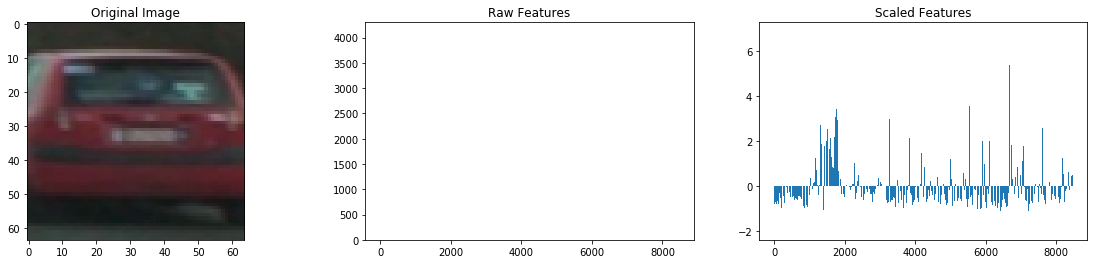

In [11]:
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(20,4))
plt.subplot(131)
plt.imshow(bgr_to_rgb(example_car))
plt.title('Original Image')
plt.subplot(132)
x = np.linspace(0,len(X[rand_car_i]),len(X[rand_car_i]))
plt.bar(x,X[rand_car_i])
plt.title('Raw Features')
plt.subplot(133)
plt.bar(x, scaled_X[rand_car_i])
plt.title('Scaled Features')
plt.show()

In [13]:
def fit_model(X_train, X_test, y_train, y_test):
    # Use a linear SVC
    svc = LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=2)
    #svc = svm.SVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    return svc

svc = fit_model(X_train, X_test, y_train, y_test)

[LibLinear]10.76 Seconds to train SVC...
Test Accuracy of SVC =  0.9896


In [38]:
import pickle
with open('svc.p', mode='wb') as f:
    pickle.dump({'svc': svc, 'scaler': X_scaler, 'orient': orient, 'pix_per_cell': pix_per_cell,
                 'cell_per_block': cell_per_block, 'spatial_size': spatial_size, 'hist_bins': hist_bins,
                 'color_space':color_space}, f)

In [39]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    box_list = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                top_left = (xbox_left, ytop_draw + ystart)
                bottom_right = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
                box_list.append((top_left,bottom_right))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return box_list, draw_img

In [40]:
dist_pickle = pickle.load(open("svc.p", "rb"))
svc = dist_pickle["svc"]
scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]

Image shape (720, 1280, 3)


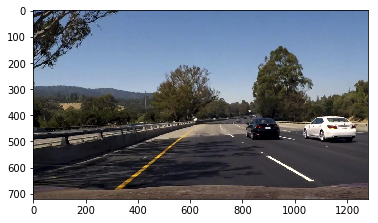

In [41]:
bbox_image = mpimg.imread('bbox-example-image.jpg')
print('Image shape', bbox_image.shape)
plt.imshow(bbox_image)

boxes found: [((816, 400), (912, 496)), ((840, 400), (936, 496)), ((840, 424), (936, 520)), ((864, 400), (960, 496)), ((1032, 400), (1128, 496)), ((1128, 400), (1224, 496)), ((1128, 424), (1224, 520)), ((1152, 424), (1248, 520))]


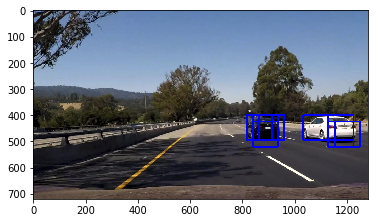

In [42]:
ystart = 400
ystop = 656
scale = 1.5
box_list, bbox_printed = find_cars(bbox_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print("boxes found:", box_list)
plt.imshow(bbox_printed)
with open('bbox_pickle.p', mode='wb') as f:
    pickle.dump({'box_list': box_list}, f)

In [97]:
from skimage import img_as_ubyte

class Heatmap():
    def __init__(self, cmap = 'jet', size = (720,1280)):
        self.size = size
        self.cmap = plt.get_cmap(cmap)
        self.heatmap = np.zeros(size)
        self.labels = None
    def add_heat(self, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))            
            if len(box) > 0:
                print("Fucking box:", box)
                self.heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
            else:
                print("Box is empty")
    def update(self, new_heatmap):
        self.heatmap[np.where(new_heatmap.heatmap == 0)] = self.heatmap[np.where(new_heatmap.heatmap == 0)] // 2
        self.heatmap = self.heatmap + new_heatmap.heatmap
    def get_rgb_image(self):
        rgba_img = self.cmap(self.heatmap/np.max(self.heatmap))
        rgb_img = np.delete(rgba_img, 3, 2)
        return img_as_ubyte(rgb_img)
    def apply_threshold(self, threshold):
        self.heatmap[self.heatmap <= threshold]  = 0
    def clip(self):
        self.heatmap = np.clip(self.heatmap, 0, 255)

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Fucking box: ((816, 400), (912, 496))
Fucking box: ((840, 400), (936, 496))
Fucking box: ((840, 424), (936, 520))
Fucking box: ((864, 400), (960, 496))
Fucking box: ((1032, 400), (1128, 496))
Fucking box: ((1128, 400), (1224, 496))
Fucking box: ((1128, 424), (1224, 520))
Fucking box: ((1152, 424), (1248, 520))


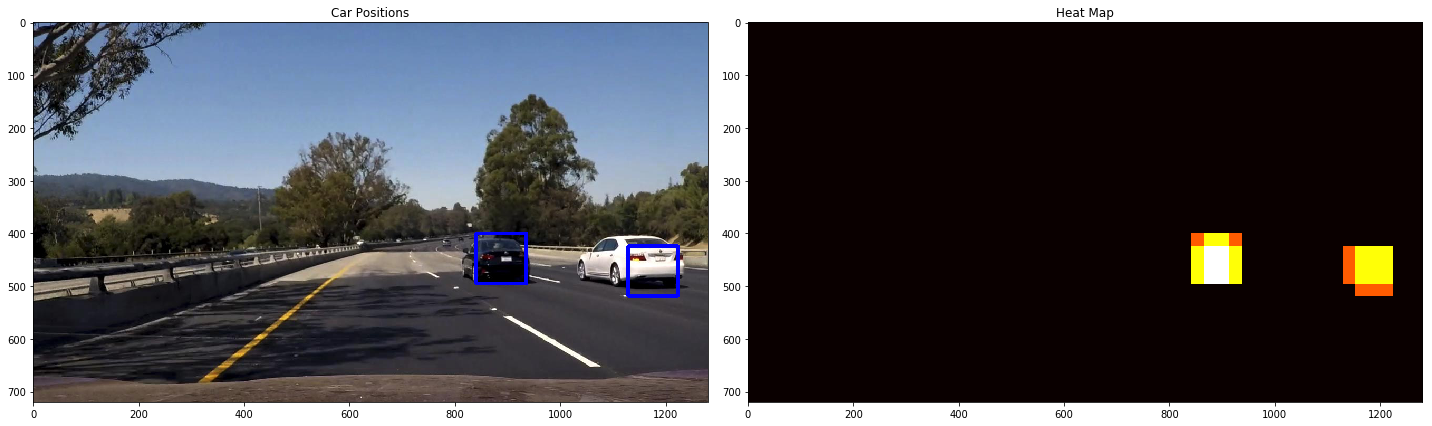

In [98]:
from scipy.ndimage.measurements import label
stored_bboxes = pickle.load(open("bbox_pickle.p", "rb"))["box_list"]

heat = Heatmap()
heat.add_heat(box_list)
heat.apply_threshold(1)
heat.clip()
labels = label(heat.heatmap)
draw_img = draw_labeled_bboxes(np.copy(bbox_image), labels)

fig = plt.figure(figsize=(20,40))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heat.heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


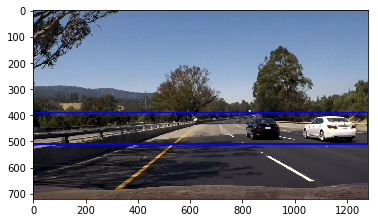

In [99]:
x_limits = [0, 1280]
rect_color = (0,0,255)
first_scanband = np.copy(bbox_image)
first_y_limit = [390, 510]
cv2.rectangle(first_band, (x_limits[0], first_y_limit[0]), (x_limits[1], first_y_limit[1]), 
              rect_color, 6)
plt.imshow(first_band)

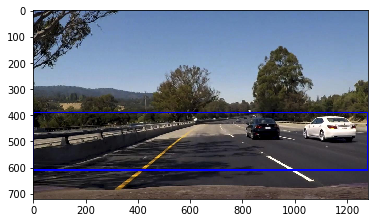

In [100]:
second_scanband = np.copy(bbox_image)
second_y_limit = [390, 610]
cv2.rectangle(second_scanband, (x_limits[0], second_y_limit[0]), (x_limits[1], second_y_limit[1]), 
              rect_color, 6)
plt.imshow(second_scanband)

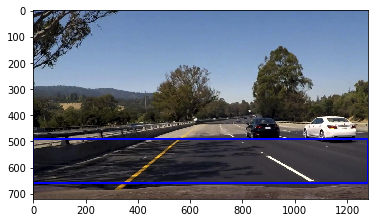

In [101]:
third_scanband = np.copy(bbox_image)
third_y_limit = [490, 660]
cv2.rectangle(third_scanband, (x_limits[0], third_y_limit[0]), (x_limits[1], third_y_limit[1]), 
              rect_color, 6)
plt.imshow(third_scanband)

In [102]:
heatmap = Heatmap()
windows_params = {'sizes':[(64, 64),(96,96),(128,128)],
               'y_limits': [first_y_limit,second_y_limit,third_y_limit],
               'x_limits': [x_limits,x_limits,x_limits],
                 'scales':[1.25,1.5]}
def process_video(frame, display = False):
    bboxes = []
    current_frame_heatmap = Heatmap()
    for i in tqdm(range(len(windows_params['scales']))):
        xstart = windows_params['x_limits'][i][0]
        xstop = windows_params['x_limits'][i][1]
        ystart = windows_params['y_limits'][i][0]
        ystop = windows_params['y_limits'][i][1]
        scale = windows_params['scales'][i]
        current_bboxes, current_img = find_cars(frame, ystart, ystop, scale, svc, 
                                X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        bboxes.extend(current_bboxes)

    current_frame_heatmap.add_heat(bboxes)
    heatmap.update(current_frame_heatmap)
    heatmap.apply_threshold(3)
    labels = label(heatmap.heatmap)
    draw_img = draw_labeled_bboxes(np.copy(frame), labels)
    im_heatmap = heatmap.get_rgb_image()
    result = cv2.addWeighted(draw_img, 1, im_heatmap, 0.4, 0)
    return result

In [ ]:
from moviepy.editor import VideoFileClip
heatmap = Heatmap()
write_output = 'video_output1.mp4'
clip1 = VideoFileClip("project_video.mp4")
write_clip = clip1.fl_image(process_video)
%time write_clip.write_videofile(write_output, audio=False)

100%|██████████| 2/2 [00:01<00:00,  1.76it/s]


[MoviePy] >>>> Building video video_output1.mp4
[MoviePy] Writing video video_output1.mp4


100%|██████████| 2/2 [00:00<00:00,  2.58it/s]


Fucking box: ((500, 410), (580, 490))


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Fucking box: ((0, 410), (80, 490))
Fucking box: ((500, 410), (580, 490))


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]


Fucking box: ((500, 410), (580, 490))


100%|██████████| 2/2 [00:00<00:00,  2.54it/s]


Fucking box: ((500, 410), (580, 490))


100%|██████████| 2/2 [00:00<00:00,  2.51it/s]


Fucking box: ((500, 410), (580, 490))


100%|██████████| 2/2 [00:00<00:00,  2.71it/s]


Fucking box: ((500, 410), (580, 490))


100%|██████████| 2/2 [00:00<00:00,  2.52it/s]


Fucking box: ((1180, 390), (1260, 470))


100%|██████████| 2/2 [00:00<00:00,  2.69it/s]


Fucking box: ((1120, 390), (1200, 470))


100%|██████████| 2/2 [00:00<00:00,  2.67it/s]


Fucking box: ((1140, 390), (1220, 470))


100%|██████████| 2/2 [00:00<00:00,  2.55it/s]


Fucking box: ((1180, 390), (1260, 470))


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('video_output1.mp4'))